In [1]:
# Recreating Nic's paper plot

import matplotlib

print(f"Matplotlib backend: {matplotlib.get_backend()}")

import pandas as pd
from Functions import *
from Telescope import *

import itertools

setTargetList('Ariel_MCS_Combined_2024-07-09')
import Ariel

import time

import warnings
warnings.filterwarnings('ignore')

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import seaborn as sns

from matplotlib import colors

from matplotlib.animation import FuncAnimation

from scipy.optimize import curve_fit

print("✓ All imports successful!")

Matplotlib backend: module://matplotlib_inline.backend_inline
________________________________________________________________
Opening all instruments into dictionary object 'instruments'...

Ariel
  |--> Ariel_MCS_Combined_2024-07-09
             |--> Ariel AIRS CH0 1.95-3.9um D=1 R=100 tau=0.18
             |--> Ariel AIRS CH0 1.95-3.9um D=1 R=3 tau=0.18
             |--> Ariel AIRS CH0 1.95-3.9um D=1 R=50 tau=0.18
             |--> Ariel AIRS CH1 3.9-7.8um D=1 R=1 tau=0.18
             |--> Ariel AIRS CH1 3.9-7.8um D=1 R=10 tau=0.18
             |--> Ariel AIRS CH1 3.9-7.8um D=1 R=30 tau=0.18
             |--> Ariel FGS1 0.6-0.8um D=1 R=1 tau=0.17
             |--> Ariel FGS2 0.8-1.1um D=1 R=1 tau=0.25
             |--> Ariel NIRSpec 1.1-1.95um D=1 R=1 tau=0.27
             |--> Ariel NIRSpec 1.1-1.95um D=1 R=10 tau=0.27
             |--> Ariel NIRSpec 1.1-1.95um D=1 R=20 tau=0.27
             |--> Ariel VISPhot 0.5-0.6um D=1 R=1 tau=0.2
_____________________________________________

In [2]:
#plot definitons 

custom_rc_params = {
    'xtick.top': True,
    'ytick.right': True,
    'xtick.direction': 'in',
    'ytick.direction': 'in',
    'xtick.minor.visible': True,
    'ytick.minor.visible': True,
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.minor.size': 4,
    'ytick.minor.size': 4,
    'xtick.major.width': 1,
    'ytick.major.width': 1,
    'xtick.minor.width': 0.8,
    'ytick.minor.width': 0.8,
    'figure.figsize': (7, 5),
    'axes.xmargin': 0.05,
    'axes.ymargin': 0.05,
    'font.size': 12,
    'legend.fontsize': 'medium',
    'axes.labelsize': 'large',
    'xtick.labelsize': 'medium',
    'ytick.labelsize': 'medium',
}

def set_grid(fig=None, ax=None):
    if fig is not None:
        for a in fig.get_axes():
            a.grid(which='major', alpha=0.3, linestyle='--', color='gray', zorder=0)
            a.grid(which='minor', alpha=0.1, linestyle='-.', color='gray', zorder=0)
        
    elif ax is not None:
        if ax.__class__ == list:
            for a in ax:
                a.grid(which='major', alpha=0.3, linestyle='--', color='gray', zorder=0)
                a.grid(which='minor', alpha=0.1, linestyle='-.', color='gray', zorder=0)
        else:
            a.grid(which='major', alpha=0.4, linestyle='--', color='gray', zorder=0)
            a.grid(which='minor', alpha=0.1, linestyle='-.', color='gray', zorder=0)
    else:
        raise ValueError('No axes or figure provided')
    


plt.rcParams.update(custom_rc_params)
plt.rcParams['figure.dpi'] = 150

In [3]:
combined = Ariel.getObservationTable("Ariel_MCS_Combined_2024-07-09")

#Estimates total time for Tier 2 TSM observations, assuming each transit takes 3× the transit duration before, during, and after
combined["Time to Tier 2 TSM [hrs]"] = combined["Tier 2 Observations TSM"] * combined["Transit Duration [hrs]"] * 3


In [4]:
# single room schoolhouse
# combined = Ariel.getObservationTable("Ariel_MCS_Combined_2024-07-09")
sorted_df = combined.sort_values(by="Time to Tier 2 TSM [hrs]", ascending=True).reset_index(drop=True)
sorted_df["Cum Sum Time to Tier 2 TSM [days]"] = sorted_df["Time to Tier 2 TSM [hrs]"].cumsum() / 24
sorted_df = sorted_df[sorted_df["Cum Sum Time to Tier 2 TSM [days]"] < 3*365]



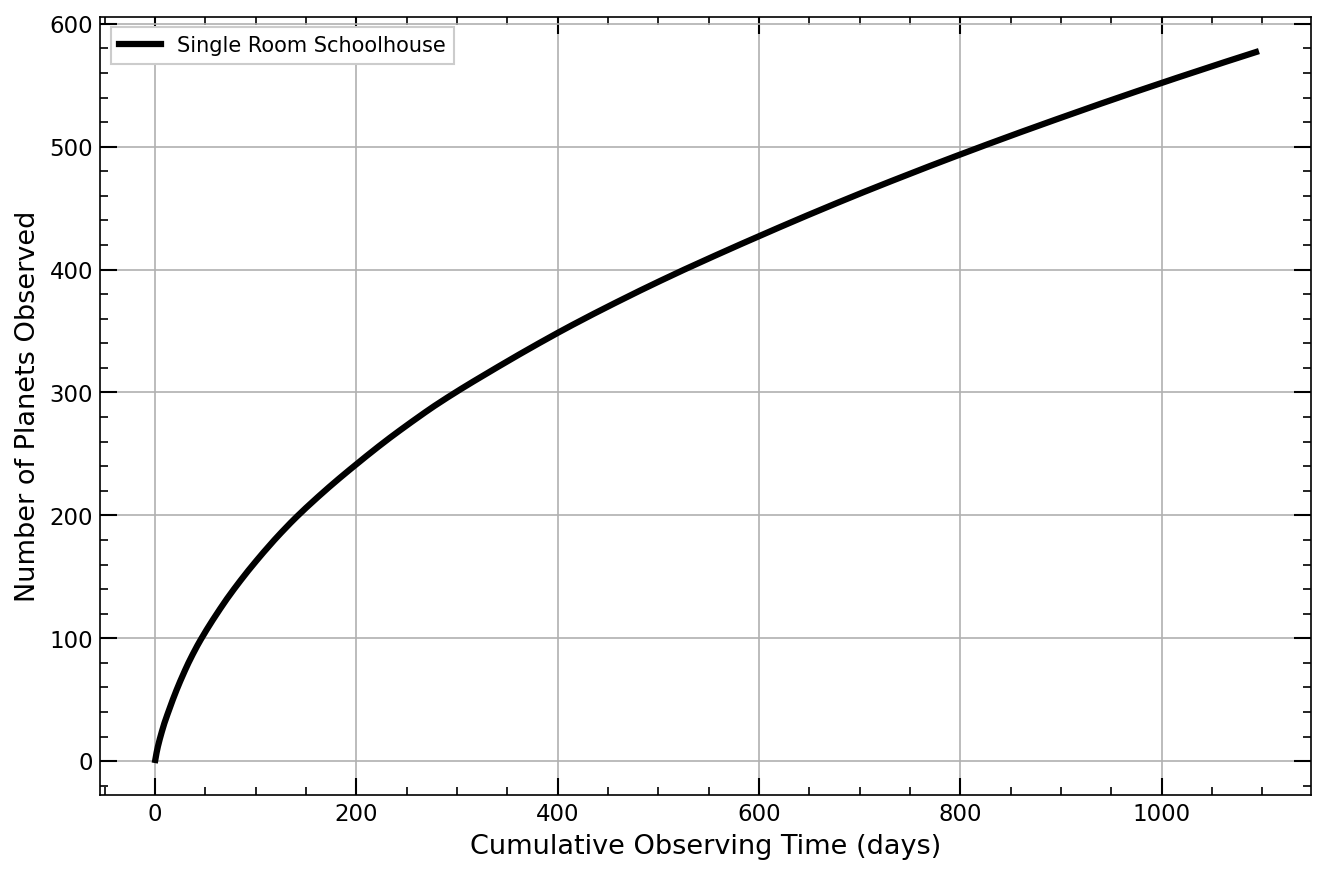

In [5]:

plt.figure(figsize=(9, 6))
plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=3)

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()


# Recreating the same plot from MCS github

In [6]:
known_ua = pd.read_csv('./target_lists_MCS/Ariel_MCS_Known_2024-07-09.csv')
tpcs_ua = pd.read_csv('./target_lists_MCS/Ariel_MCS_TPCs_2024-07-09.csv')
tpcs_ua = tpcs_ua.rename(columns={"Transit Duration [hr]": "Transit Duration [hrs]"})

combined_ua = pd.concat([known_ua, tpcs_ua], ignore_index=True)

#### Saving ONLY the relevant data for Alex:

In [36]:
# # This is for viewing the column names
# for x in combined_ua.columns:
#     print(x)

target_columns = ['Star Temperature [K]', 'Planet Temperature [K]', 'Planet Radius [Rjup]', 'Transit Duration T14 [s]', 'Tier 2 Observations']
reduced_data = combined_ua[target_columns]

# create a new column 'total observation time' that is the product of Tier 2 Observations and Transit Duration T14 [s]
reduced_data['Total Observation Time [days]'] = reduced_data['Tier 2 Observations'] * reduced_data['Transit Duration T14 [s]'] / (60 * 60 * 24)

# Get rid of the Tier 2 Observations and Transit Duration T14 [s] columns
reduced_data = reduced_data.drop(columns=['Tier 2 Observations', 'Transit Duration T14 [s]'])

# Multipy the Total Observation Time [y] by a factor of 3 to account for the time needed to observe before and after the transit
reduced_data['Total Observation Time [days]'] *= 3

reduced_data.to_csv('reduced_data.csv')

In [7]:
# 3-year limit in seconds
time_limit = 365 * 24 * 3600 

# using T14 [s]
# tier 2 known
tier2_known = known_ua.copy()
tier2_known['total_obs_time_14'] = tier2_known['Transit Duration T14 [s]'] * tier2_known['Tier 2 Observations']
duration_col14 = 'total_obs_time_14'
tier2_known_sorted = tier2_known.sort_values(by=duration_col14)
tier2_known_sorted['cumulative_obs_time_14'] = tier2_known_sorted['total_obs_time_14'].cumsum()
tier2_known_final = tier2_known_sorted[tier2_known_sorted['cumulative_obs_time_14'] < time_limit]
tier2_known_final['cumulative_targets'] = range(1, len(tier2_known_final) + 1)

#tpcs
tier2_tpcs = tpcs_ua.copy()
tier2_tpcs['total_obs_time_14'] = tier2_tpcs['Transit Duration T14 [s]'] * tier2_tpcs['Tier 2 Observations']
tier2_tpcs_sorted = tier2_tpcs.sort_values(by=duration_col14)
tier2_tpcs_sorted['cumulative_obs_time_14'] = tier2_tpcs_sorted['total_obs_time_14'].cumsum()
tier2_tpcs_final = tier2_tpcs_sorted[tier2_tpcs_sorted['cumulative_obs_time_14'] < time_limit]
tier2_tpcs_final['cumulative_targets'] = range(1, len(tier2_tpcs_final) + 1)

#combined
tier2_combined = combined_ua.copy()
tier2_combined['total_obs_time_14'] = tier2_combined['Transit Duration T14 [s]'] * tier2_combined['Tier 2 Observations']
tier2_combined_sorted = tier2_combined.sort_values(by=duration_col14)
tier2_combined_sorted['cumulative_obs_time_14'] = tier2_combined_sorted['total_obs_time_14'].cumsum()
tier2_combined_final = tier2_combined_sorted[tier2_combined_sorted['cumulative_obs_time_14'] < time_limit]
tier2_combined_final['cumulative_targets'] = range(1, len(tier2_combined_final) + 1) 

# using duration [hrs]
time_limit_hrs = 365 *24
tier2_known_hrs = known_ua.copy()
tier2_known_hrs['total_obs_time_hrs'] = tier2_known_hrs['Transit Duration [hrs]'] * tier2_known_hrs['Tier 2 Observations']
duration_col_hrs = 'total_obs_time_hrs'
tier2_known_sorted_hrs = tier2_known_hrs.sort_values(by=duration_col_hrs)
tier2_known_sorted_hrs['cumulative_obs_time_hrs'] = tier2_known_sorted_hrs['total_obs_time_hrs'].cumsum()
tier2_known_final_hrs = tier2_known_sorted_hrs[tier2_known_sorted_hrs['cumulative_obs_time_hrs'] < time_limit_hrs]
tier2_known_final_hrs['cumulative_targets'] = range(1, len(tier2_known_final_hrs) + 1)

tier2_tpcs_hrs = tpcs_ua.copy()
tier2_tpcs_hrs['total_obs_time_hrs'] = tier2_tpcs_hrs['Transit Duration [hrs]'] * tier2_tpcs_hrs['Tier 2 Observations']
tier2_tpcs_sorted_hrs = tier2_tpcs_hrs.sort_values(by=duration_col_hrs)
tier2_tpcs_sorted_hrs['cumulative_obs_time_hrs'] = tier2_tpcs_sorted_hrs['total_obs_time_hrs'].cumsum()
tier2_tpcs_final_hrs = tier2_tpcs_sorted_hrs[tier2_tpcs_sorted_hrs['cumulative_obs_time_hrs'] < time_limit_hrs]
tier2_tpcs_final_hrs['cumulative_targets'] = range(1, len(tier2_tpcs_final_hrs) + 1)

#combined
tier2_combined_hrs = combined_ua.copy()
tier2_combined_hrs['total_obs_time_hrs'] = tier2_combined_hrs['Transit Duration [hrs]'] * tier2_combined_hrs['Tier 2 Observations']
tier2_combined_sorted_hrs = tier2_combined_hrs.sort_values(by=duration_col_hrs)
tier2_combined_sorted_hrs['cumulative_obs_time_hrs'] = tier2_combined_sorted_hrs['total_obs_time_hrs'].cumsum()
tier2_combined_final_hrs = tier2_combined_sorted_hrs[tier2_combined_sorted_hrs['cumulative_obs_time_hrs'] < time_limit_hrs]
tier2_combined_final_hrs['cumulative_targets'] = range(1, len(tier2_combined_final_hrs) + 1)


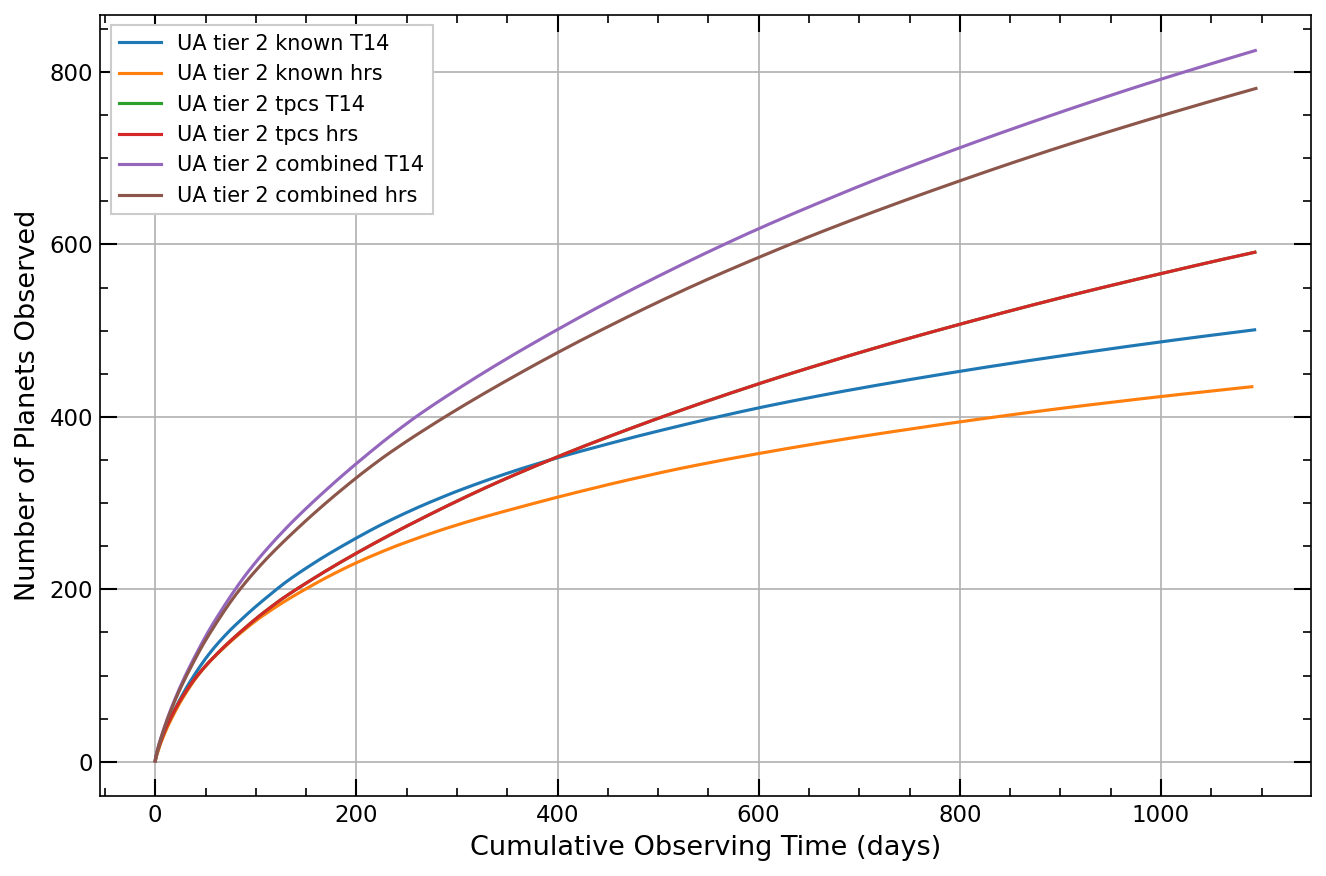

In [8]:
plt.figure(figsize=(9, 6))

plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='UA tier 2 combined T14')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='UA tier 2 combined hrs')

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

# Combining both

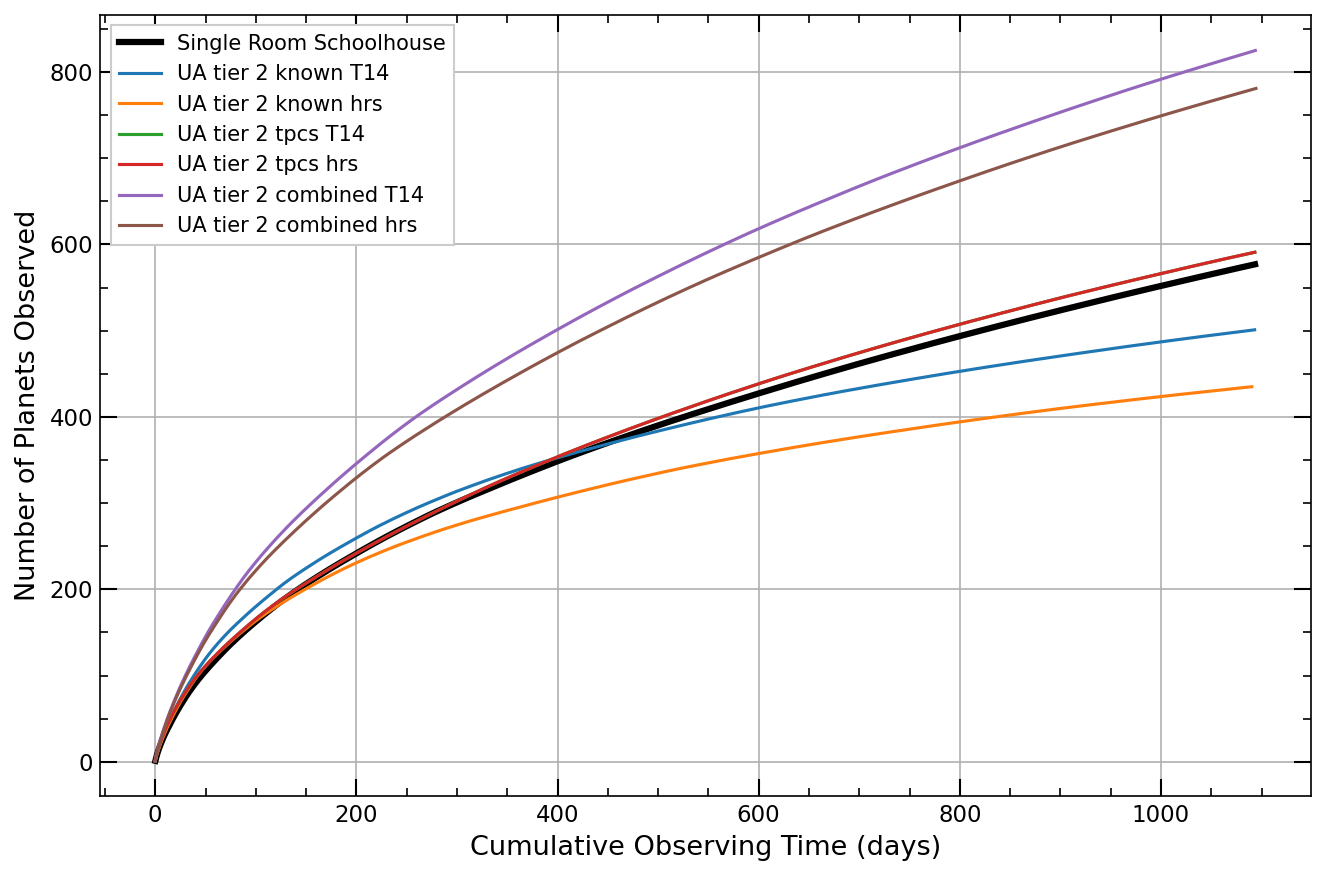

In [9]:


plt.figure(figsize=(9, 6))

plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=3)

plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='UA tier 2 combined T14')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='UA tier 2 combined hrs')

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


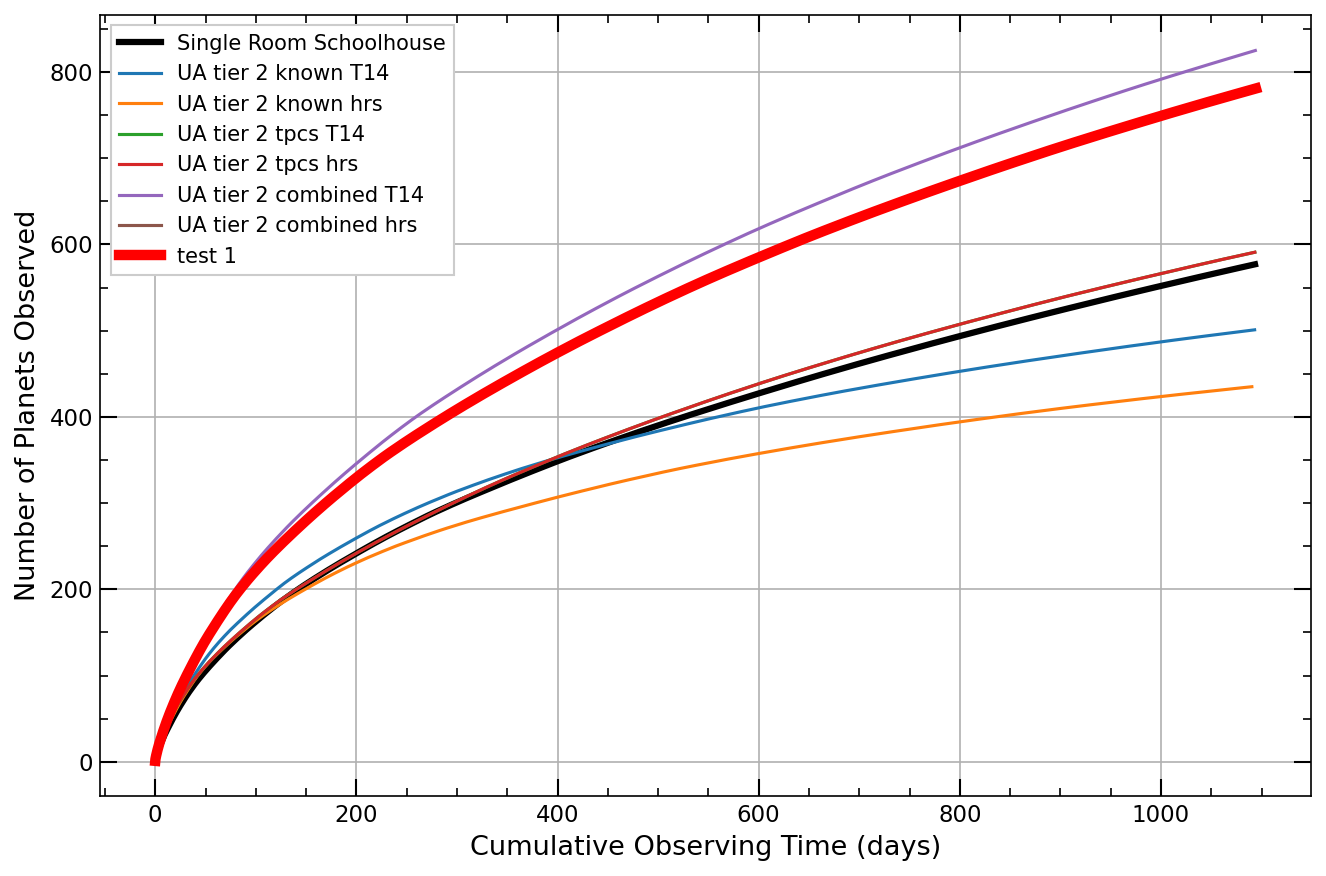

In [10]:
## TEST 1 ##

# trying to take the same cvs for combined, keeping the method as usual

test1 = combined.copy()
test1['total_obs_time_hrs'] = test1['Transit Duration [hrs]'] * test1['Tier 2 Observations']
test1_sorted = test1.sort_values(by='total_obs_time_hrs')
test1_sorted['cumulative_obs_time_hrs'] = test1_sorted['total_obs_time_hrs'].cumsum()
test1_final = test1_sorted[test1_sorted['cumulative_obs_time_hrs'] < time_limit_hrs]
test1_final['cumulative_targets'] = range(1, len(test1_final) + 1)

# plotting 

plt.figure(figsize=(9, 6))

plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=3)

plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='UA tier 2 combined T14')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='UA tier 2 combined hrs')

plt.plot((test1_final["cumulative_obs_time_hrs"]/24)*3,test1_final['cumulative_targets'],c='red',lw=5,label='test 1')

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


In [11]:
# Add a Source column based on the "Known" boolean
combined["Source"] = combined["Known"].map({True: "Known", False: "TPC"})

sorted_df = combined.sort_values(by="Time to Tier 2 TSM [hrs]", ascending=True).reset_index(drop=True)
sorted_df["Cum Sum Time to Tier 2 TSM [days]"] = sorted_df["Time to Tier 2 TSM [hrs]"].cumsum() / 24
sorted_df = sorted_df[sorted_df["Cum Sum Time to Tier 2 TSM [days]"] < 3*365]

source_counts = sorted_df["Source"].value_counts()
num_tpc = source_counts.get("TPC", 0)
num_known = source_counts.get("Known", 0)

print('Nic\'s paper combined:\n',num_tpc*100/(num_tpc+num_known),'% of TPCs',num_known*100/(num_tpc+num_known),'% of known planets')

known_ua_test = known_ua.copy()
known_ua_test["Source"] = "Known"

tpcs_ua_test = tpcs_ua.copy()
tpcs_ua_test["Source"] = "TPC"

combined_ua = pd.concat([known_ua_test, tpcs_ua_test], ignore_index=True)
indices_comb2 = combined_ua[combined_ua['Tier 2 Observations'] < 20].index
tier2_combined = combined_ua.loc[indices_comb2].copy()
tier2_combined['total_obs_time_14'] = tier2_combined['Transit Duration T14 [s]'] * tier2_combined['Tier 2 Observations']
tier2_combined_sorted = tier2_combined.sort_values(by='total_obs_time_14')
tier2_combined_sorted['cumulative_obs_time_14'] = tier2_combined_sorted['total_obs_time_14'].cumsum()
tier2_combined_sorted['cumulative_targets'] = range(1, len(tier2_combined_sorted) + 1)
time_limit = 365 * 24 * 3600
tier2_combined_final = tier2_combined_sorted[tier2_combined_sorted['cumulative_obs_time_14'] < time_limit]

source_counts2 = tier2_combined_final["Source"].value_counts()
num_tpc2 = source_counts2.get("TPC", 0)
num_known2 = source_counts2.get("Known", 0)

print('\nUA test combined:\n',num_tpc2*100/(num_tpc2+num_known2),'% of TPCs',num_known2*100/(num_tpc2+num_known2),'% of known planets')



Nic's paper combined:
 52.16637781629116 % of TPCs 47.83362218370884 % of known planets

UA test combined:
 57.49086479902558 % of TPCs 42.50913520097442 % of known planets


Conclusion: we tried to see if the csv file used at the beginning was the difference, but it is not. We also see a small difference in the proportion of known and tpcs in the final combined file, but it stays quite similar. Now trying something else.

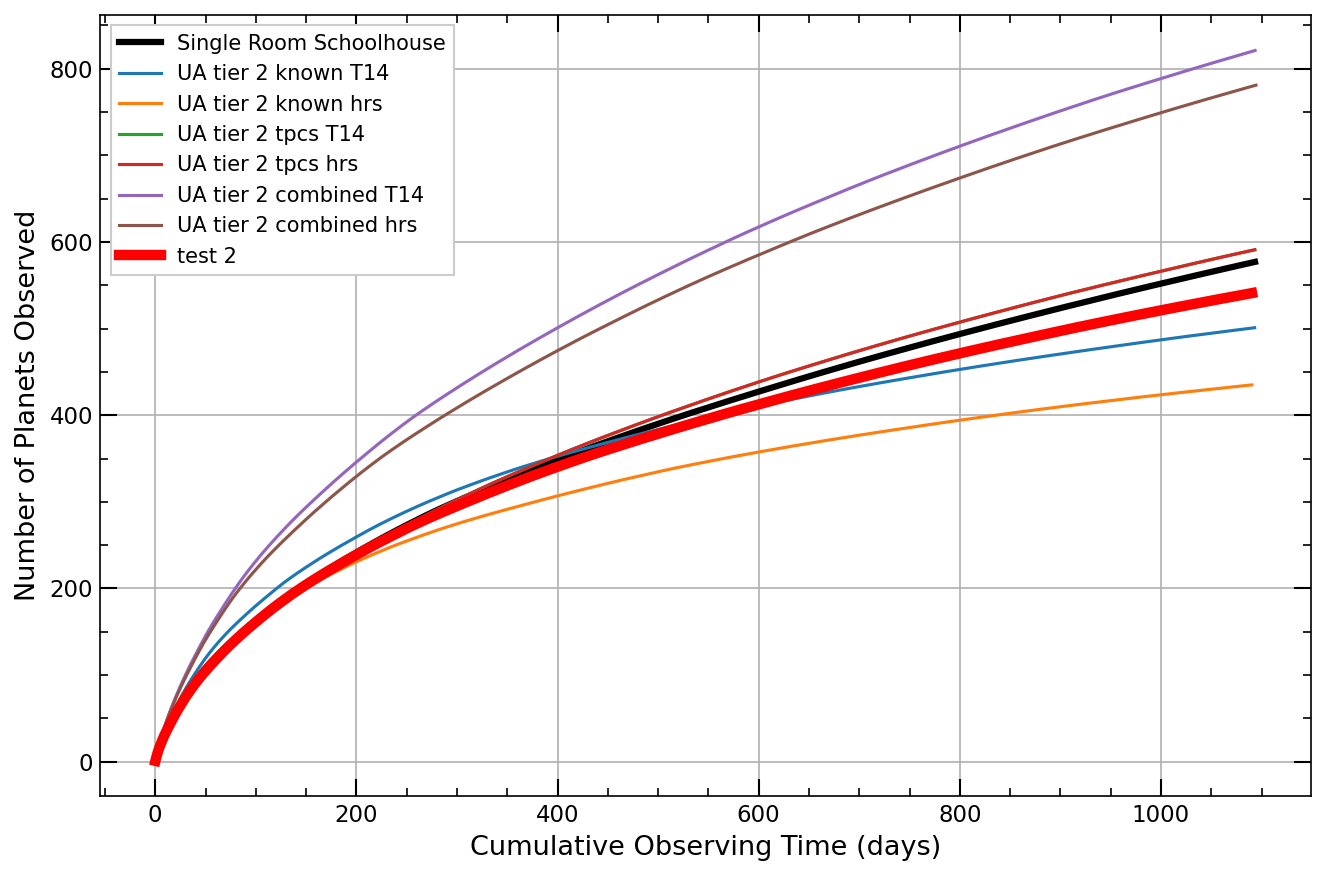

In [12]:
## TEST 2 ##
# trying to take the same cvs for combined, using the recalculation of TSM
# I changed it in this version of the notebook but before I was adding a limit at 20 observations
# because it is what is recommended for Ariel tier 2
# I removed it I don't think it's relevant for this study, and Nic didn't take it into account 

indices_test1 = combined[combined[f'Tier 2 Observations'] < 20].index
test2 = combined.loc[indices_test1].copy()
test2['total_obs_time_hrs'] = test2['Transit Duration [hrs]'] * test2['Tier 2 Observations TSM']
test2_sorted = test2.sort_values(by='total_obs_time_hrs')
test2_sorted['cumulative_obs_time_hrs'] = test2_sorted['total_obs_time_hrs'].cumsum()
test2_final = test2_sorted[test2_sorted['cumulative_obs_time_hrs'] < time_limit_hrs]
test2_final['cumulative_targets'] = range(1, len(test2_final) + 1)

# plotting 


plt.figure(figsize=(9, 6))

plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=3)

plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='UA tier 2 combined T14')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='UA tier 2 combined hrs')

plt.plot((test2_final["cumulative_obs_time_hrs"]/24)*3,test2_final['cumulative_targets'],c='red',lw=5,label='test 2')

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


In test number 2 we try to take the column recalculated by Ben named 'Tier 2 Observations TSM', which looks different than the one from the MCS named 'Tier 2 Observation'. We see that it is closer to the curve of the paper but not completely the same, that is because I was putting a limit at 20 observations, which is a recommendation for Ariel tier 2 observations. This is a mistake on my side as I don't think it's relevant on this study and Nic didn't apply this filter in his paper. Let's try removing it.

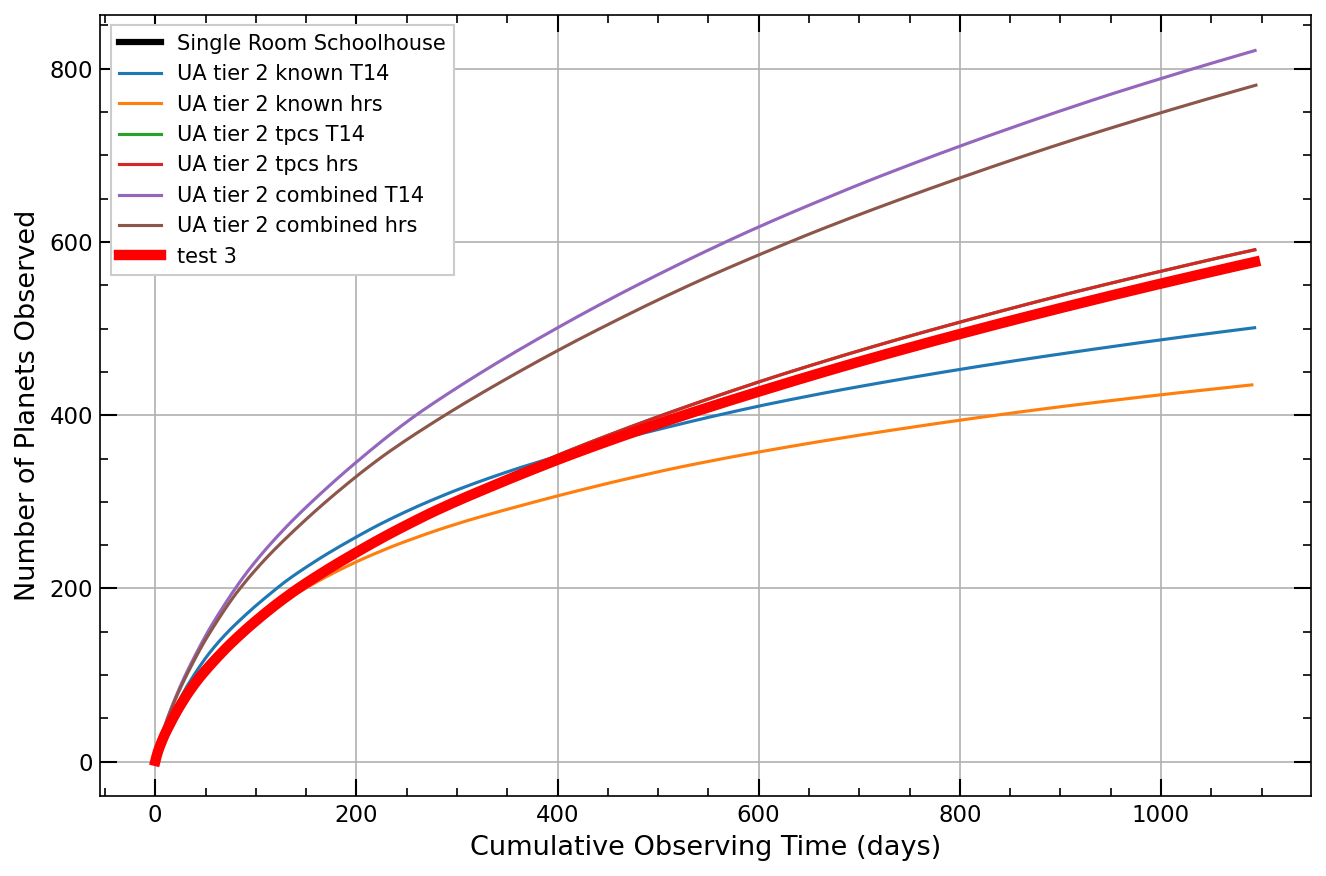

In [13]:
## TEST 3 ##

# trying to take the same cvs for combined, using the recalculation of TSM
# not using the filter for Tier 2

test3 = combined.copy()
test3['total_obs_time_hrs'] = test3['Transit Duration [hrs]'] * test3['Tier 2 Observations TSM']
test3_sorted = test3.sort_values(by='total_obs_time_hrs')
test3_sorted['cumulative_obs_time_hrs'] = test3_sorted['total_obs_time_hrs'].cumsum()
test3_final = test3_sorted[test3_sorted['cumulative_obs_time_hrs'] < time_limit_hrs]
test3_final['cumulative_targets'] = range(1, len(test3_final) + 1)

# plotting 


plt.figure(figsize=(9, 6))

plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=3)

plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='UA tier 2 combined T14')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='UA tier 2 combined hrs')

plt.plot((test3_final["cumulative_obs_time_hrs"]/24)*3,test3_final['cumulative_targets'],c='red',lw=5,label='test 3')

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

In test number 3 we try to take the column recalculated by Ben named 'Tier 2 Observations TSM' and also removing the limit at 20 observations. We obtain the same as the paper!!! But we also found out that they are using the column 'Transit Duration [hrs]', which contains NaN. Let's try to see what happens with the column 'Transit Duration T14 [s]'.

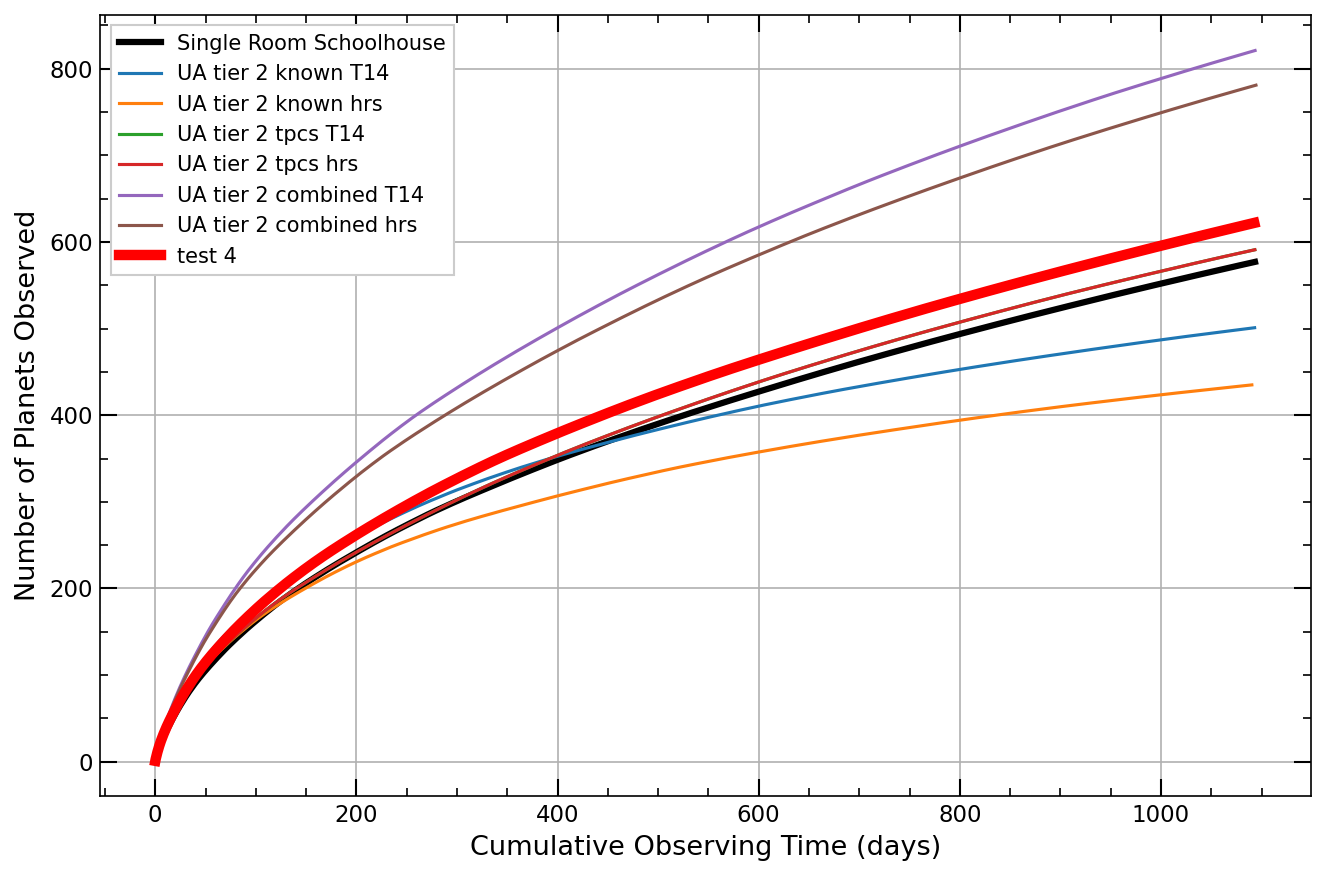

In [14]:
## TEST 4 ##

# trying to take the same cvs for combined, using the recalculation of TSM
# not using the filter for Tier 2
# taking the T14 instead of duration in hrs

test4 = combined.copy()
test4['total_obs_time_14'] = test4['Transit Duration T14 [s]'] * test4['Tier 2 Observations TSM']
test4_sorted = test4.sort_values(by='total_obs_time_14')
test4_sorted['cumulative_obs_time_14'] = test4_sorted['total_obs_time_14'].cumsum()
test4_final = test4_sorted[test4_sorted['cumulative_obs_time_14'] < time_limit]
test4_final['cumulative_targets'] = range(1, len(test4_final) + 1)

# plotting 


plt.figure(figsize=(9, 6))

plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=3)

plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='UA tier 2 combined T14')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='UA tier 2 combined hrs')

plt.plot((test4_final['cumulative_obs_time_14']/60/60/24)*3,test4_final['cumulative_targets'],c='red',lw=5,label='test 4')

plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()

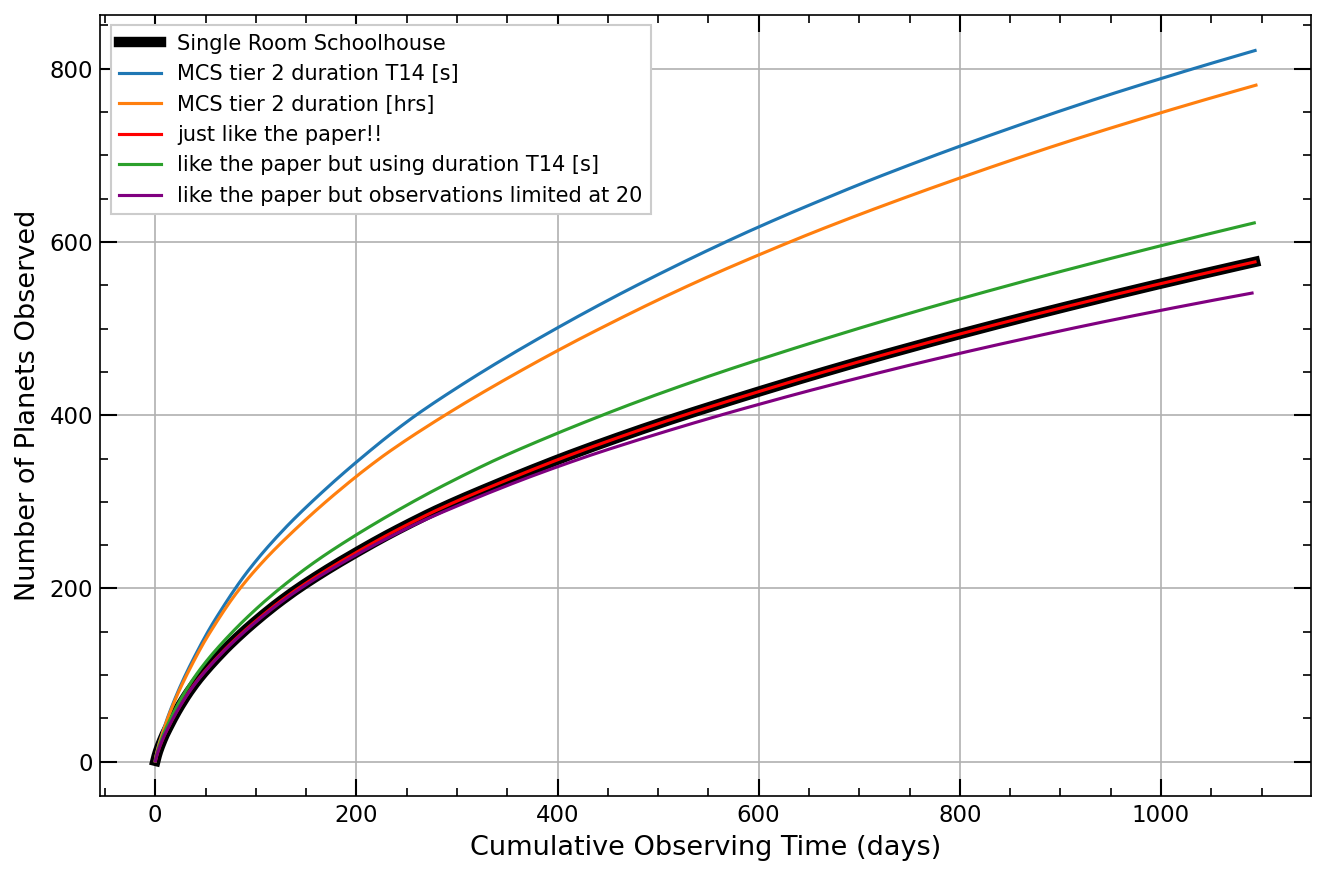

In [15]:
## PLOT SEND TO THE COLLABORATION VIA EMAIL ##

plt.figure(figsize=(9, 6))

plt.plot(sorted_df["Cum Sum Time to Tier 2 TSM [days]"], np.arange(1, len(sorted_df) + 1), c='black', label="Single Room Schoolhouse", lw=5)

#plt.plot((tier2_known_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_known_final['cumulative_targets'],label ='UA tier 2 known T14')
#plt.plot((tier2_known_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_known_final_hrs['cumulative_targets'],label ='UA tier 2 known hrs')

#plt.plot((tier2_tpcs_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_tpcs_final['cumulative_targets'],label ='UA tier 2 tpcs T14')
#plt.plot((tier2_tpcs_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_tpcs_final_hrs['cumulative_targets'],label ='UA tier 2 tpcs hrs')

plt.plot((tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3,  tier2_combined_final['cumulative_targets'],label ='MCS tier 2 duration T14 [s]')
plt.plot((tier2_combined_final_hrs["cumulative_obs_time_hrs"]/24)*3,  tier2_combined_final_hrs['cumulative_targets'],label ='MCS tier 2 duration [hrs]')
plt.plot((test3_final["cumulative_obs_time_hrs"]/24)*3,test3_final['cumulative_targets'],c='red',label='just like the paper!!')
plt.plot((test4_final['cumulative_obs_time_14']/60/60/24)*3,test4_final['cumulative_targets'],label='like the paper but using duration T14 [s]')
plt.plot((test2_final["cumulative_obs_time_hrs"]/24)*3,test2_final['cumulative_targets'],c='purple',label='like the paper but observations limited at 20')
plt.xlabel("Cumulative Observing Time (days)", fontsize=13)
plt.ylabel("Number of Planets Observed", fontsize=13)
plt.xticks(fontsize=11)
plt.yticks(fontsize=11)
plt.legend(fontsize=10, framealpha=1, fancybox=False, loc='upper left')
plt.grid(True)
plt.tight_layout()

# Show plot
#plt.savefig('./cmoparison_cumsum_observation_time.png', dpi=500)
plt.show()

The general conclusion is: we found out what was happenning! We agreed to use the curve that is named 'MCS tier 2 duration T14 [s]' for the rest of the study.

In [16]:
# Let's save the right things to plot

np.save('cumulative_obs_time_days.npy',(tier2_combined_final["cumulative_obs_time_14"]/60/60/24)*3)
np.save('cumulative_targets.npy',tier2_combined_final['cumulative_targets'])
